# Particular Matter Data in Munich

Julia Herzen, Klaus Achterhold, Clemens Schmid, Manuel Schultheiss

**This year we want to make you aware of the public climate school (https://studentsforfuture.info/public-climate-school/) from November 23 to November 27. Hence, this is a climate related exercise.**

This exercise will show you some more features of matplotlib.
We collected some environmental data like particle count or temperature for various time and position points in Munich. Your task is to plot this data on a map.

*Some background:  Environemental data was collected using various sensors mounted on a Raspberry Pi. The particular matter data was collected using a PMS5003 sensor. Here suspending particles are radiated, scattering light is detected and a curve with light change over time is generated. (Source: https://www.aqmd.gov/docs/default-source/aq-spec/resources-page/plantower-pms5003-manual_v2-3.pdf). That way the number of particles for various sizes can be measured. Please note, due to the moving sensor, the data may not be as accurate as measured on a sensor without motion.*

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cbook as cbook
import numpy as np
import matplotlib.pylab as plt
import json

First we load our data. The data measured is stored a list of objects. Each object contains the following information we are interested in:

* **latitude**: The latitude position of the measurement
* **longitude**: The longitude position of the measurement
* **humidity**: Humidity sensor raw value
* **temp**: Temperature
* **lux**: Light
* **PMgreater1.0um**: PM1.0 in ug/m3 (ultrafine particles):
* **PMgreater2.5um**: PM2.5 in ug/m3 (combustion particles, organic compounds, metals)
* **PMgreater10.0um**: PM1.0 in ug/m3 (dust, pollen, mould spores)


To print all key you can use `print(json_data[0].keys())`.

In [2]:
with open('sensordata.json') as json_file:
    json_data = json.load(json_file)

To print the latitude information of the first measurement (index 0), you can use

In [3]:
print(json_data[0]["latitude"])

48.30348066


Now try to print **longitude** ("longitude") and **combustion particle** ("PMgreater2.5um") information

In [4]:
print(json_data[0]["longitude"]) # ?
print(json_data[0]["PMgreater2.5um"]) # ?

11.6624641
0


Next, we load a map image of Munich where we want to display the measurements on:

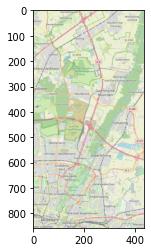

In [5]:
img = mpimg.imread('map.png')
plt.imshow(img)

As a grayscale background looks nicer for our measurements, we want to convert the image to a grayscale image, e.g. from shape (857, 437, 4) to shape (857, 437). You can mean over the color channel to obtain a grayscale image.

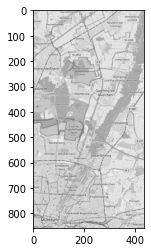

In [6]:
img_grayscale = img[:,:,0:3].mean(axis=-1)
plt.imshow(img_grayscale, cmap="gray")

Next we need to convert longitude and latitude information to a grid system. **You can ignore this part!**

For those interested, we need two corresponding coordinates on each the map (x,y pixel positions) and the dataset (longitutde and latitude). Then we can calculate the distance between the x and y coordinates  and remap the longitude/latitude coordinates of our dataset to the x and y coordinates of our map image.

In [7]:
lat_start, lon_start = json_data[0]["latitude"], json_data[0]["longitude"] # longitude latitude start on data

x_start, y_start = 317, 96 # The startpoint on the map image

lat_end, lon_end = 48.1360292, 11.5997386
x_end, y_end = 131, 824

range_lon, range_lat  =  lon_start-lon_end, lat_start-lat_end
range_x, range_y = x_start-x_end, y_end - y_start

def transform_lon_lat_to_image(longitude, latitude):
    return (longitude-lon_start)/range_lon*range_x + x_start, -(latitude-lat_start)/range_lat*range_y + y_start

**Your next task** is to use the `transform_lon_lat_to_image` function defined above to convert longitude and latitude to the x-y coordinates on the image:

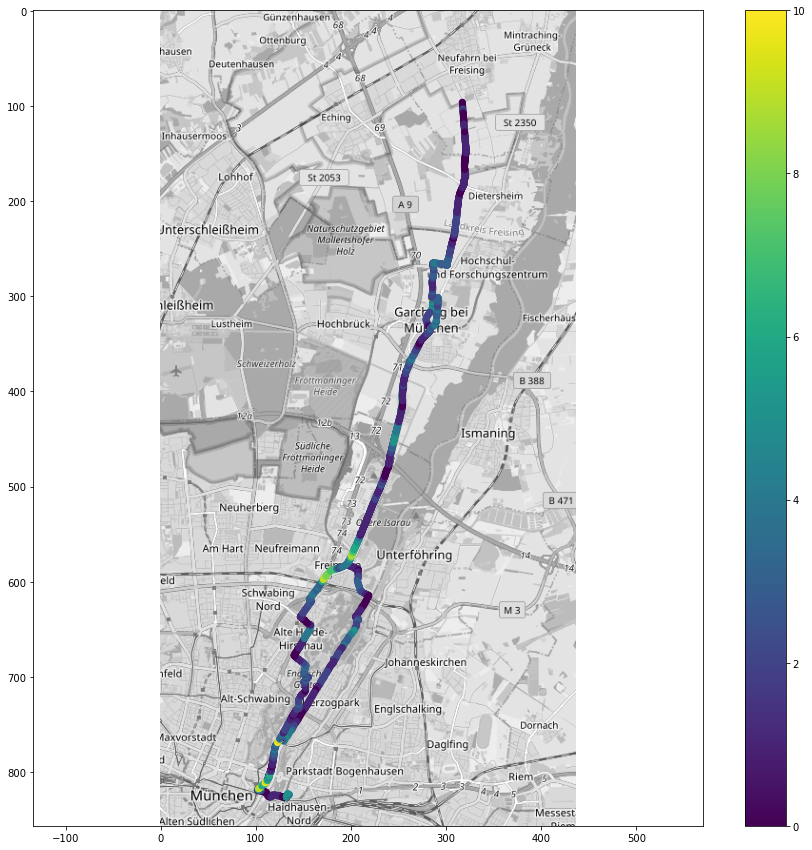

In [8]:
plt.figure(figsize=(15, 15)) # Use figsize to enlarge the map image
plt.clf()


x,y, particles, small_particles = [],[], [], [] # Here we generate 4 empty lists at once


for data in json_data:
    x_img, y_img = transform_lon_lat_to_image(data["longitude"], data["latitude"] )

    if "PMgreater2.5um" in data: # Check if sensor data exists for a certain point using the `in` operator
        y.append(y_img)
        x.append(x_img)
        particles.append(data["PMgreater2.5um"])
        small_particles.append(data["PMgreater1.0um"])

# We limit the colorbar using the vmax argument. This means 
# every value above 10 will be set to the maximum value of the colorbar.
# In order to use a differnt key than `PMgreater2.5um` you need to adapt vmax!

sc = plt.scatter(x,y,c=particles,zorder=1, vmax=10) 
plt.colorbar(sc)

plt.imshow(img_grayscale, zorder=0, cmap="gray")
plt.axis('equal')
plt.show()

Now let's plot our values as a time-series. We use a technique called list-comprehensions (https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) to get a list of the data values in our list `json_data` we want to plot. As some objects do not contain particular matter information, we if the `PMgreater2.5um` key is contained using the `in` operator.

In [9]:
list_of_key_values = [item["PMgreater2.5um"] for item in json_data if "PMgreater2.5um" in item]

Now plot the values for PMgreater1.0um, PMgreater5.0um, PMgreater0.3um, PMgreater2.5um as a time-series:

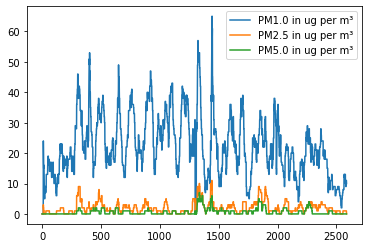

In [10]:
plt.plot([item["PMgreater1.0um"] for item in json_data if "PMgreater2.5um" in item], label = "PM1.0 in ug per m³") # ?
plt.plot([item["PMgreater2.5um"] for item in json_data if "PMgreater2.5um" in item], label = "PM2.5 in ug per m³") # ?
plt.plot([item["PMgreater5.0um"] for item in json_data if "PMgreater2.5um" in item], label = "PM5.0 in ug per m³") # ?


plt.legend()
plt.show(); 

The allowed yearly average for PM1.0 is around 40ug/m³ (https://www.air-q.com/grenzwerte). On the plot above we can immeditaley see that the average on different locations is below this value. But let us calculate  the exact average PM1.0 value on our bike tour. To calculate the mean you can use the `np.mean()` function of numpy.

In [11]:
print("PM1.0 average is ", np.mean([item["PMgreater1.0um"] for item in json_data if "PMgreater2.5um" in item]))

PM1.0 average is  22.3401623502126


For some positions, the value is above 40. However, please note that this depends much on the where the measurement took place (e.g. at night the PM1.0 values are a lot of lower). So in general, the PM1.0 value seems to fit within the yearly limits.


Last, lets plot some more parameters like light, humidity and temperature. The lux value should decrease rapidly in the second half of the plot, as these data points were collected at sunset.

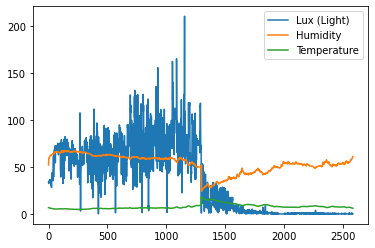

In [12]:
plt.plot([item["lux"] for item in json_data ], label = "Lux (Light)")  
plt.plot([item["humidity"] for item in json_data ], label = "Humidity") 
plt.plot([item["temp"] for item in json_data  ], label = "Temperature")  
plt.legend()

**Hint:** When working with time series data or geospatial data, you may want to have a look at the **pandas** and **geopandas** libraries, which make a lot of work more easy.